## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Reinforcement Learning

In [5]:
!pip install gymnasium[toy_text]
from time import sleep
from IPython.display import clear_output
import random
import gymnasium as gym
import numpy as np
import pygame

import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from google.colab.patches import cv2_imshow
from google.colab import output
np.random.seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 836 kB 5.1 MB/s 
     |████████████████████████████████| 18.3 MB 152 kB/s 


## The Environment

We will be using [OpenAI's gym](https://gym.openai.com/docs/) for rendering environments and we will specifically use the [Taxi-v3](https://gym.openai.com/envs/Taxi-v3/) environment for this exercise. In the next few cells we'll visualize the environment and explain the rules and rewards. It will be up to you to create an agent that interacts with the environment and learns a policy (Q table) from those interactions.

Current State: 146


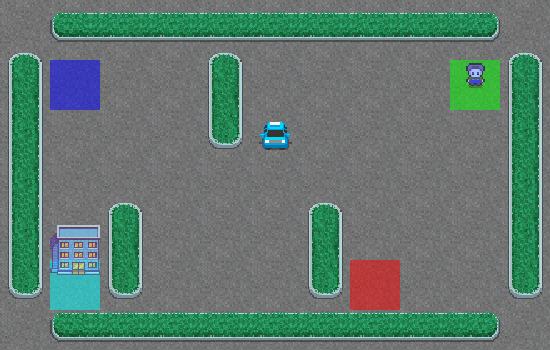

In [22]:
# Load the Taxi-v3 environment
env = gym.make("Taxi-v3",render_mode="rgb_array").env

# Set the RNG so we'll get the same results with every notebook run
# env.seed(0)
env.reset()

# Visualize the initial (and current) state
print(f"Current State: {env.s}")

cv2_imshow(env.render())

The above section just rendered an example view of the environment. For the Taxi-v3 environment,

1. The location of the taxi is randomly chosen with each new play of the environment.
1. Red, Green, Purple, Blue areas are all the possible pickup or dropoff locations for a passenger. These locations are the same for every play of the environment.
1. The passenger appears at the pickup location, which is one of the 4 available areas. The pickup location is randomly chosen with each new play of the environment.
1. The building appears at the passenger's dropoff location. The dropoff location is randomly chosen with each new play of the environment.

The reward scheme for this environment is as follows, "your job is to pick up the passenger at one location and drop them off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

In [23]:
# The gym environment contains info on how many states are possible and
# how many actions an agent can take. Let's find out...

print(f"The action space is discrete with {env.action_space.n} possibilities.")
print(f"The observation (state) space is discrete with {env.observation_space.n} possibilities.")

The action space is discrete with 6 possibilities.
The observation (state) space is discrete with 500 possibilities.


The following actions are possible in the environment:

1. Move south
1. Move north
1. Move east
1. Move west
1. Pick up passenger
1. Drop off passenger

Note that there are 500 state space possibilties. Think about the different states that may exist, and how that totals to 500 possibilities. See the [blog post](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/) for a full explanation.

## Create a Q table

In the cell below, implement a function that initializes a Q table.

In [97]:
def initialize_q_table(env):
    """Initialize a Q table for an environment with all 0s
    
    Args:
        env (gym.envs): The environment
    
    Returns:
        np.array: The Q table of shape (observation space size, action space size)
    """
    # YOUR CODE HERE
    return np.zeros([env.observation_space.n, env.action_space.n])


In [98]:
assert initialize_q_table(env).shape == (500, 6)
xenv = gym.make("FrozenLake-v1").env
assert initialize_q_table(xenv).shape == (16, 4)

## Action selection

In the cell below, implement a function that chooses an action, given a particular environment state (row of a Q table).

In [86]:
def select_action(q_row, method, epsilon=0.5):
    """Select the appropriate action given a Q table row for the state and a chosen method
    
    Args:
        q_row (np.array): The row from the Q table to utilize
        method (str): The method to use, either "random" or "epsilon"
        epsilon (float, optional): Defaults to 0.5. The epsilon value to use for
                                   epislon-greedy action selection
    
    Raises:
        NameError: If method specified is not supported
    
    Returns:
        int: The index of the action to apply
    """
    if method not in ["random", "epsilon"]:
        raise NameError("Undefined method.")
    
    # YOUR CODE HERE
    if method == 'epsilon':
      if random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, len(q_row)) #env.action_space.sample()
      else:
        action = np.argmax(q_row)
    elif method == 'random':
      action = np.random.randint(0, len(q_row)) #env.action_space.sample()
    return action


In [87]:
assert select_action(np.array([1,2,3,4]), "epsilon", epsilon=0) == 3
assert select_action(np.array([1,2,3,4]), "epsilon", epsilon=1) in range(4)
assert select_action(np.array([1,2,3,4]), "random") in range(4)

## Actions and updates

The `env.step(action)` method takes a parameter that is the (index of the) action the agent decides to apply and returns 4 values:
1. The new state
1. The received reward
1. Whether or not the task ask been completed
1. Miscellaneous information

Let's look at an example...

In [62]:
action = 0
vals = env.step(action)
print(f"An example returned from a step with action 0:")
print(vals)
print('')
print(f"New state: {vals[0]}")
print(f"Return (reward): {vals[1]}, based on performing action {action}")
print(f"Task complete: {vals[2]}")
print(f"Additional info: {vals[3]}")

An example returned from a step with action 0:
(412, -1, False, False, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})

New state: 412
Return (reward): -1, based on performing action 0
Task complete: False
Additional info: False


## Learning

During Q-learning, we update our agent's Q-table after each action, based on the previous state, the action, and the reward. In the cell below implement the update equation discussed in class. Note that the `calculate_new_q_val` function only returns the updated Q value for that specific (state, action) pair. It does not return the entire table.

In [63]:
def calculate_new_q_val(q_table, state, action, reward, next_state, alpha, gamma):
    """Calculate the updated Q table value for a particular state and action given the necessary parameters
    
    Args:
        q_table (np.array): The Q table
        state (int): The current state of the simulation's index in the Q table
        action (int): The current action's index in the Q table
        reward (float): The returned reward value from the environment
        next_state (int): The next state of the simulation's index in the Q table (Based on the environment)
        alpha (float): The learning rate
        gamma (float): The discount rate
    
    Returns:
        float: The updated action-value expectation for the state and action
    """

    # YOUR CODE HERE
    output = (1-alpha)*q_table[state,action] + alpha*(reward + gamma*np.max(q_table[next_state,action]))
    return output

In [64]:
test_q = np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4]])
assert -0.05 < calculate_new_q_val(test_q, 0, 1, 10, 1, 0.1, 0.2) - 2.88 < 0.05
assert -0.05 < calculate_new_q_val(test_q, 0, 1, 1, 1, 0.1, 0.1) - 1.94 < 0.05
assert -0.05 < calculate_new_q_val(test_q, 0, 1, -11, 2, 0.1, 0.1) - 0.74 < 0.05

## Training

You'll train two agents using an epsilon greedy approach with two different epsilon values. Recall that a higher epsilon value means that the agent will do more exploration and less exploitation, during training.

In [65]:
params1 = {
    "method": "epsilon",
    "epsilon": 0.1,
    "alpha": 0.1,
    "gamma": 0.5
}

In [66]:
params2 = {
    "method": "epsilon",
    "epsilon": 0.3,
    "alpha": 0.1,
    "gamma": 0.5
}

In the `train_agent` function below, an agent is trained over the course of many simulations of the environment/game. Each simulation is run until the task is completed (which could take longer during early learning, when the agent has a poor Q table--e.g., doesn't "know anything").

You need to create code that will (1) select an action based on the current state, (2) execute that action in the gym environment, and (3) update the Q table based on the results returned by the gym environment.

To aid in visualization of how well and quickly an agent is learning you will (4) add the step reward to the total reward, for the given simulation iteration.

In [81]:
def train_agent(env, params, n_sims=100):
    """Run a training simulation in an environment and return its Q table
    
    Args:
        env (gym.envs): The environment to train in
        params (dict): The parameters needed to train the simulation, stored with these keys:
                         'method' (for action selection--either 'epsilon' or 'random'),
                         'epsilon',
                         'alpha',
                         'gamma'
        n_sims (int, optional): Defaults to 100. The number of simulations to run for training
    
    Returns:
        q_table (np.array): The trained Q table from the simulation
        total_rewards (np.array): Total (summed) rewards for each of the n_sim training simulations
    """
    q_table = initialize_q_table(env)
    total_rewards = np.zeros(n_sims)
    cum_reward = 0
    
    for i_sim in range(n_sims):
        env.reset()
        current_state = env.s
        done = False        
        
        while not done:
            # 1. Get the next action based on current state
            # 2. Execute that action and get the results from the environment
            # 3. Update the Q table
            # 4. Add the step reward to the reward total, for this (i_sim'th) simulation
            
            # YOUR CODE HERE
            action = select_action(q_table[current_state], params['method'], params['epsilon'])
            
            next_state, reward, done, _, _ = env.step(action)

            q_table[current_state, action] = calculate_new_q_val(q_table, next_state, action, reward, next_state, params['alpha'], params['gamma'])

            cum_reward += reward
            total_rewards[i_sim] = cum_reward

            # Prep for next iteration
            current_state = next_state 

        if (i_sim+1) % 1000 == 0:
            print(f"Simulation #{i_sim+1:,} complete.")
        
    return q_table, total_rewards

Now we'll train our two agents.

In [89]:
%%time

n_train_simulations = 100
q_table1, total_rewards = train_agent(env, params1, n_train_simulations)

CPU times: user 4 s, sys: 280 ms, total: 4.28 s
Wall time: 4.08 s


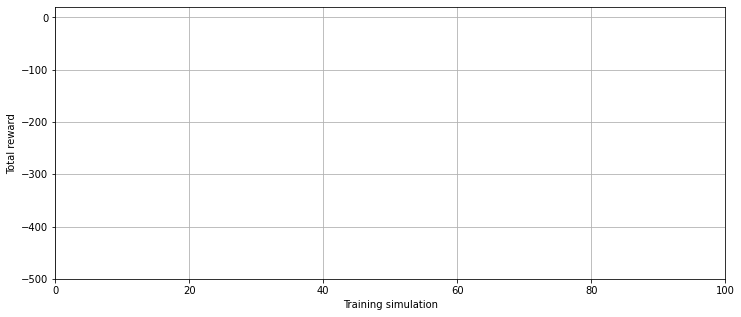

In [90]:
# Let's get a rough visual of how quickly that agent learned...

plt.figure(figsize=(12, 5))
idx = np.arange(0, n_train_simulations, 10)
plt.plot(idx, total_rewards[idx], '.')
plt.xlabel('Training simulation')
plt.ylabel('Total reward')
plt.grid()
_ = plt.axis([0, n_train_simulations, -500, 20])

In [88]:
%%time

n_train_simulations = 100
q_table2, total_rewards = train_agent(env, params2, n_train_simulations)

CPU times: user 4.72 s, sys: 385 ms, total: 5.1 s
Wall time: 4.91 s


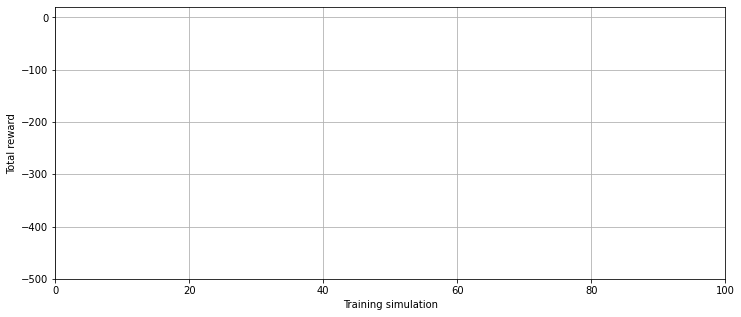

In [91]:
# Let's get a rough visual of how quickly that agent learned...

plt.figure(figsize=(12, 5))
idx = np.arange(0, n_train_simulations, 10)
plt.plot(idx, total_rewards[idx], '.')
plt.xlabel('Training simulation')
plt.ylabel('Total reward')
plt.grid()
_ = plt.axis([0, n_train_simulations, -500, 20])

## Testing

Having trained two agents, new we want to test them. The agents are no longer learning, so we'll want to execute the actions that have the highest action-value for a given state--that is, there is no randomness to the agents' actions.

In the cell below your code should (1) determine the best action for the current state and (2) execute that action in the gym environment.

Note that because the agent is not acting deterministically, it may get "stuck" and never complete the task, so there is code that limits the duration (steps) of the simulation.

In [95]:
def test_agent(env, q_table, n=100, render=False):
    """Test an agent using a pre-trained Q table
    
    Args:
        env (gym.envs): The environment to test
        q_table (np.array): The pretrained Q table
        n (int, optional): Defaults to 100. The number of test iterations to run
        render (bool, optional): Defaults to False. Whether to display a rendering of the environment
    
    Returns:
        np.array: Array of length n with each value being the cumulative reward achieved in the simulation
    """
    rewards = []
    
    for i in range(n):
        env.reset()
        current_state = env.s

        tot_reward = 0
        done = False
        step = 0

        while not done:
            
            # 1. Determine the best action
            # 2. Execute that action
            
            # YOUR CODE HERE
            action = np.argmax(q_table[current_state,:])
            next_state, reward, done, _, _ = env.step(action)
            

            tot_reward += reward
            step +=1
            if render:
                clear_output(wait=True)
                print(f"Simulation: {i + 1}")
                cv2_imshow(env.render())
                print(f"Step: {step}")
                print(f"Current State: {current_state}")
                print(f"Action: {action}")
                print(f"Reward: {reward}")
                print(f"Total rewards: {tot_reward}")
                sleep(.2)
            if step == 50:
                print("Agent got stuck. Quitting...")
                sleep(.5)
                break
        
        rewards.append(tot_reward)
    
    return np.array(rewards)

Because each run of the simulation environment has a different initial state (passenger location and destination, and taxi location) we'll test the agents multiple times, and the compare median scores (total reward).

In [96]:
# To see the testing simulations running, set:
#    render=True
# You should do this for a least a few simulations, to
# qualitatively observe the agent. You can then stop
# the notebook kernel and reset render=False.

rewards1 = test_agent(env, q_table1, 100, render=False)

Agent got stuck. Quitting...
Agent got stuck. Quitting...
Agent got stuck. Quitting...
Agent got stuck. Quitting...
Agent got stuck. Quitting...
Agent got stuck. Quitting...
Agent got stuck. Quitting...
Agent got stuck. Quitting...


KeyboardInterrupt: ignored

In [ ]:
# To see the testing simulations running, set:
#    render=True

rewards2 = test_agent(env, q_table2, 100, render=False)

In [ ]:
print(f"Total reward for agent with params1: mean={np.mean(rewards1):0.2f}, median={np.median(rewards1)}")
print(f"Total reward for agent with params2: mean={np.mean(rewards2):0.2f}, median={np.median(rewards2)}")

plt.figure(figsize=(12, 5))
n_bins = 20

plt.subplot(1,2,1)
plt.hist(rewards1, bins=n_bins)
plt.xlabel('Total reward')
plt.ylabel('Count')
plt.title('Agent with params1')

plt.subplot(1,2,2)
plt.hist(rewards2, bins=n_bins)
plt.xlabel('Total reward')
plt.ylabel('Count')
_ = plt.title('Agent with params2')

In [ ]:
# Your models may sometimes not pass the below asserts but you should be able to get it at least work sometimes
# To avoid any issues with grading, we've commented them out.
# To make the most out of this activity, please uncomment them and get them to at least occasionally pass
# assert np.median(rewards1) > 5
# assert np.median(rewards2) > 5

## Your exploration

Like an agent that is learning, you should explore how agent performance changes when you alter some of the learning parameters. You can re-run this notebook multiple times, altering the values in the `params` dicts.

- How well and quickly does training go when using various values for epsilon, alpha, and gamma?
- How well and quickly does training go when using the 'random' method (which is equivalent to epsilon==1)?
- Does an agent improve if you train it for more than 10,000 simulation runs?

## Feedback

In [ ]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    raise NotImplementedError()